# Dilepton analysis  


This is an example of a simple dilepton analysis, quite similar to the notebook called "Dilepton_analysis_noData.ipynb", but with some differences. The most obvious difference is that we here also include real data. This example also has a slightly more advanced event selection.  

**Notice:** This is *only an example* on how to do this. Feel free to be creative, and to find better and/or more elegant ways of doing the various steps! 

## 1. Reading the dataset

In [1]:
TChain *background = new TChain("mini");
TChain *data = new TChain("mini"); 

A list of all the background samples and their IDs can be found in **Background_samples.txt**. We read that list, and add all the samples to the TChain. We also (for later convenience) make a vector containing the dataset IDs. 

In [2]:
TString sample; 
TString path; 
vector<Int_t> dataset_IDs;
Int_t DSID;

In [3]:
ifstream infile("input/bgsamples.dat");

In [4]:
TString datadir("/media/data/tmp")

(TString &) "/media/data/tmp"[15]


In [5]:
infile.clear();
infile.seekg(0, ios::beg);  // Start at the beginning of the file
background->Reset(); // Reset the TChain (if necessary)  
while(infile >> sample >> DSID){
    path = datadir+"/MC/"+sample; // Specify path to the samples 
    background->Add(path);  
    dataset_IDs.push_back(DSID);
}

In [6]:
data->Reset(); 
data->Add(datadir + "/Data/DataEgamma.root"); 
data->Add(datadir + "/Data/DataMuons.root"); 

Next we define the variables we want to include in the analysis, and link them to branches in the TTree. A few things to notice at this point: 
-  In this example we will only study events with two leptons, so the vectorial variables only need to be two dimensional. 
-  The variables are here given names corresponding to the branches in the TTree. This is not necessary, so if you want to give them other names you are free to do so. 
-  The variable called "channelNumber" is the same as we have called "dataset ID" above. These terms are used interchangeably. 

In [7]:
Int_t lep_n, lep_charge[2], lep_type[2], channelNumber; 
Float_t lep_pt[2], lep_E[2], lep_phi[2], lep_eta[2], mcWeight; 
Bool_t passGRL, hasGoodVertex, trigE, trigM, lep_trigMatched[2]; 
Float_t lep_etcone20[2], lep_ptcone30[2]; 
Int_t lep_flag[2]; 

In [8]:
Float_t scaleFactor_PILEUP, scaleFactor_ELE, scaleFactor_MUON, scaleFactor_BTAG, scaleFactor_TRIGGER, scaleFactor_JVFSF, scaleFactor_ZVERTEX; 

In [9]:
// For MC:  
background->SetBranchAddress("lep_n",      &lep_n);
background->SetBranchAddress("lep_charge", &lep_charge);
background->SetBranchAddress("lep_pt",     &lep_pt);
background->SetBranchAddress("lep_eta",    &lep_eta);
background->SetBranchAddress("lep_phi",    &lep_phi);
background->SetBranchAddress("lep_E",      &lep_E);
background->SetBranchAddress("channelNumber", &channelNumber);
background->SetBranchAddress("mcWeight", &mcWeight); 
background->SetBranchAddress("scaleFactor_PILEUP", &scaleFactor_PILEUP ); 
background->SetBranchAddress("scaleFactor_ELE", &scaleFactor_ELE ); 
background->SetBranchAddress("scaleFactor_MUON", &scaleFactor_MUON ); 
background->SetBranchAddress("scaleFactor_BTAG", &scaleFactor_BTAG ); 
background->SetBranchAddress("scaleFactor_TRIGGER", &scaleFactor_TRIGGER ); 
background->SetBranchAddress("scaleFactor_JVFSF", &scaleFactor_JVFSF ); 
background->SetBranchAddress("scaleFactor_ZVERTEX", &scaleFactor_ZVERTEX ); 
background->SetBranchAddress("lep_flag", &lep_flag); 
background->SetBranchAddress("lep_ptcone30", &lep_ptcone30); 
background->SetBranchAddress("lep_etcone20", &lep_etcone20); 
background->SetBranchAddress("passGRL", &passGRL); 
background->SetBranchAddress("hasGoodVertex", &hasGoodVertex); 

// For data 
data->SetBranchAddress("lep_n",      &lep_n);
data->SetBranchAddress("lep_charge", &lep_charge);
data->SetBranchAddress("lep_type",   &lep_type);
data->SetBranchAddress("lep_pt",     &lep_pt);
data->SetBranchAddress("lep_eta",    &lep_eta);
data->SetBranchAddress("lep_phi",    &lep_phi);
data->SetBranchAddress("lep_E",      &lep_E);
data->SetBranchAddress("channelNumber", &channelNumber);
data->SetBranchAddress("passGRL", &passGRL); 
data->SetBranchAddress("hasGoodVertex", &hasGoodVertex); 
data->SetBranchAddress("lep_flag", &lep_flag); 
data->SetBranchAddress("lep_ptcone30", &lep_ptcone30); 
data->SetBranchAddress("lep_etcone20", &lep_etcone20); 

## 2. Making (a lot of) histograms

Now that we have read our dataset we want to start analyzing the data. To do so we need to put the data into histograms. For reasons that will become clear later in the analysis we must (for each variable) make one histogram per dataset ID. (We have 31 background samples, so if we want to study 10 variables we have to make 310 histograms!) A very elegant way of dealing with all these histograms is by using [map](http://www.cplusplus.com/reference/map/map/)s (the C$++$ equivalent of Python dictionaries). Below we define one map for each variable. Here the *key values* are the dataset IDs, while the *mapped values* are the histograms.   

In [10]:
map<Int_t, TH1*> hist_mll;

In [11]:
for(const auto & i:dataset_IDs){
    hist_mll[i] = new TH1F(); 
}

In [12]:
for(const auto & i:dataset_IDs){
    hist_mll[i]->SetNameTitle("hist_mll", "Invariant mass"); 
    hist_mll[i]->SetBins(20,0,500); 
}

For data it is only necessary with one histogram for each variable: 

In [13]:
hist_mll_d = new TH1F(); 

In [14]:
hist_mll_d->SetNameTitle("hist_mll", "Invariant mass"); 
hist_mll_d->SetBins(20,0,500); 

### 2.1 Fill the histograms 
We can now loop over all events in our dataset, implement desired cuts, and fill the histograms we created above. In this example we choose only events containing exactly to same flavour leptons with opposite charge (i.e. $e^+e^-$ or $\mu^+\mu^-$). 
Before starting the loop we extract the total number of entries (events) in the TChain. We also make [TLorentzVector](https://root.cern.ch/doc/master/classTLorentzVector.html)s, which are very practical for handling the kinematics of the leptons, e.g. calculating the invariant mass of the two leptons. 

In [15]:
TLorentzVector l1, l2, dileptons; 

In [16]:
TChain *dataset = new TChain("mini"); 
int isData; 
int nentries; 
Float_t W; 
int n_bjets; 

In [17]:
// Reset histograms (in case you have filled them before) 
for(const auto & i:dataset_IDs){ 
    hist_mll[i]->Reset(); 
}

hist_mll_d->Reset(); 
// Loop through all events 
for(isData = 0; isData<2; isData++){

    if(isData == 1){ 
        nentries = data->GetEntries();
        dataset = data; 
        cout << "Running over data..." << endl; 
    }
    else {
        nentries = background->GetEntries();;
        dataset = background;      
        cout << "Running over background..." << endl; 
    }

    for (int i = 0; i < nentries; i++){

        if( i%1000000 == 0 && i>0){ cout << i/1000000 << " million events processed" << endl;}
        dataset->GetEntry(i); // We "pull out" the i'th entry in the chain. The variables are now 
                              // available through the names we have given them. 
        
        //if(!( i%100000==0)){ continue; }

        // Data quality cuts: 

        if(passGRL == 0){ continue; } 
        if(hasGoodVertex == 0){ continue; }
        //if(trigM == 0 && trigE == 0){ continue; } 

        // Require "good leptons": 

        if( lep_pt[0]/1000.0 < 25 ){ continue; }
        if( lep_etcone20[0]/lep_pt[0] > 0.15 ){ continue; }
        if( lep_ptcone30[0]/lep_pt[0] > 0.15 ){ continue; }
        if( !(lep_flag[0] & 512) ){ continue; }

        if( lep_pt[1]/1000.0 < 25 ){ continue; }
        if( lep_etcone20[1]/lep_pt[1] > 0.15 ){ continue; }
        if( lep_ptcone30[1]/lep_pt[1] > 0.15 ){ continue; }
        if( !(lep_flag[1] & 512) ){ continue; }

        // Event selection: 

        // Cut #1: Require (exactly) 2 leptons
        if(lep_n != 2){ continue; }
        // Cut #2: Require opposite charge
        if(lep_charge[0] == lep_charge[1]){ continue; }
        // Cut #3: Require same flavour (2 electrons or 2 muons)
        if(lep_type[0] != lep_type[1]){ continue; }

        // Set Lorentz vectors: 
        l1.SetPtEtaPhiE(lep_pt[0]/1000., lep_eta[0], lep_phi[0], lep_E[0]/1000.);
        l2.SetPtEtaPhiE(lep_pt[1]/1000., lep_eta[1], lep_phi[1], lep_E[1]/1000.);
        // Variables are stored in the TTree with unit MeV, so we need to divide by 1000 
        // to get GeV, which is a more practical and commonly used unit. 

        dileptons = l1 + l2;       

        if(isData == 1){
            hist_mll_d->Fill(dileptons.M());
        }
        else{    
            W = mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_BTAG*scaleFactor_TRIGGER*scaleFactor_JVFSF*scaleFactor_ZVERTEX; 
            hist_mll[channelNumber]->Fill(dileptons.M(), W);
        }

    }

}    
cout << "Done!" << endl; 

Running over background...
1 million events processed
2 million events processed
3 million events processed
4 million events processed
5 million events processed
6 million events processed
7 million events processed
8 million events processed
9 million events processed
10 million events processed
11 million events processed
12 million events processed
13 million events processed
14 million events processed
15 million events processed
16 million events processed
17 million events processed
18 million events processed
19 million events processed
20 million events processed
21 million events processed
22 million events processed
23 million events processed
24 million events processed
25 million events processed
26 million events processed
27 million events processed
28 million events processed
29 million events processed
30 million events processed
31 million events processed
32 million events processed
33 million events processed
34 million events processed
35 million events processed
36

We have now done the "heavy lifting" of an analysis, i.e. looping through all the events. Usually in such an analysis we create new ROOT files where we store the histograms we made above, and then analyse the output in a separate program/script. The advantage of doing this is that you can do the rest of the analysis in another language, e.g. Python, since we are done with part that requires the speed of C$++$. If you want to write ROOT files you can check out the [TFile](https://root.cern.ch/doc/master/classTFile.html) class reference. In this example we will however carry on in C$++$. But even if you only work in C++ it can be practical to write the histograms to file, so that you don't need to run the loop _every time_ you open the notebook.  

## 3. Scale and classify the histograms (MC only) 

Before we are ready to make plots we need to do some further processing of the histograms we made above. The information necessary for doing the two steps below is found in the file **Infofile.txt**.   
1. We need to **scale** the histograms to the right cross section and luminosity. Why? When making the MC samples a certain number of events is simulated, which will usually not correspond to the number of events in our data. The expected number of events from a certain kind of process is given by $N=\sigma L$, where $\sigma$ is the cross section and $L$ is the integrated luminosity. Therefore we need to scale each histogram by a scale factor <br> <br>
$$sf = \frac{N}{N_{MC}} = \frac{ \sigma L }{N_{MC}},$$ <br>  where $N_{MC}$ is the number of generated MC events.  <br> <br>
2. We also need to **classify** the background processes into different categories. This is necessary when we eventually want to make the characteristic colorful background plots you might have seen before.  

### 3.1 Make new histograms 
Maybe a bit depressingly we have to make a set of new histograms, this time corresponding to the different background categories, instead of the dataset IDs. Notice that these new histograms are made in a very similar way as above, i.e. with the same range and binning. 

In [18]:
map<TString, TH1*> H_mll; 

In [19]:
vector<TString> Backgrounds; 

In [20]:
Backgrounds = {"Higgs","Diboson", "Wjets", "DY", "singleTop", "ttbar", "Zjets"}; 

In [21]:
for(const auto & i:Backgrounds){
    H_mll[i] = new TH1F(); 
}

In [22]:
for(const auto & i:Backgrounds){
    H_mll[i]->SetNameTitle("hist_mll", "Invariant mass"); 
    H_mll[i]->SetBins(20,0,500); 
}

### 3.2 Scale and add histograms 
Now we read our info file, scale all (old) histograms, and then add them to the new histograms we just defined.  

In [23]:
ifstream info("input/infofile.dat"); 
TString process; 
TString type; 
Int_t dsid; 
Int_t n_events; 
Double_t red_eff; // Efficiency  
Double_t sum_w; // Sum of weights 
Double_t x_sec; // Cross section 
Double_t L; // Integrated luminosity (pb)
Double_t SF; // Total scale factor 

In [24]:
L = 1000.6; 

In [25]:
for(const auto & i:Backgrounds){
    H_mll[i]->Reset(); 
}

In [26]:
info.clear();
info.seekg(0, ios::beg);  
while(info >> process >> type >> dsid >> n_events >> red_eff >> sum_w >> x_sec){
    SF = x_sec*L/(sum_w*red_eff); 

    hist_mll[dsid]->Scale(SF);     
    H_mll[type]->Add(hist_mll[dsid]);     
}

### 3.3 Color the histograms 
Make yet another map, this time containing the colors you want the backgrounds to have, and then set the colors of your histograms. Note that colors are defined by integers in ROOT. If you are not happy with the colors chosen below you can have look at the [TColor](https://root.cern.ch/doc/master/classTColor.html) class reference for more options. 

In [27]:
map<TString, Int_t> colors; 

In [28]:
colors["Diboson"] = kGreen; 
colors["Zjets"] = kYellow; 
colors["ttbar"] = kRed;
colors["singleTop"] = kBlue-7; 
colors["Wjets"] = kBlue+3; 
colors["DY"] = kOrange+1; 
colors["Higgs"] = kMagenta; 

In [29]:
for(const auto h:Backgrounds){
    H_mll[h]->SetFillColor(colors[h]);     
    H_mll[h]->SetLineColor(colors[h]); 
}

## 4. Stack and plot the histograms

Finally we have arrived to the part where we can plot the results of all the work done above. For each variable we need to stack the backgrounds on top of each other, which is done by using the [THStack](https://root.cern.ch/doc/master/classTHStack.html) class. In the example below we do this for two variables; invariant mass and missing $E_T$.   

In [30]:
THStack *stack_mll = new THStack("Invariant mass", "");

In [31]:
for(const auto h:Backgrounds){
    stack_mll->RecursiveRemove(H_mll[h]); // Remove previously stacked histograms  
    stack_mll->Add(H_mll[h]); 
}    

Now we make a legend (see [TLegend](https://root.cern.ch/doc/master/classTLegend.html)), and add  the different backgrounds. Next we make a canvas (see [TCanvas](https://root.cern.ch/doc/master/classTCanvas.html)), which is allways necessary when we want to make a plot. Then you draw the stack and the legend, and display them by drawing the canvas. We can also specify axis labels and a bunch of other stuff. 

In [32]:
gStyle->SetLegendBorderSize(0); // Remove (default) border around legend 
TLegend *leg = new TLegend(0.65, 0.60, 0.9, 0.85); 

In [33]:
leg->Clear();
for(const auto i:Backgrounds){
    leg->AddEntry(H_mll[i], i, "f");  // Add your histograms to the legend
} 
leg->AddEntry(hist_mll_d, "Data", "lep"); 

In [34]:
TCanvas *C = new TCanvas("c", "c", 600, 600);

In [35]:
gPad->SetLogy(); // Set logarithmic y-axis

In [36]:
hist_mll_d->SetLineColor(kBlack); 
hist_mll_d->SetMarkerStyle(kFullCircle); 
hist_mll_d->SetMarkerColor(kBlack); 

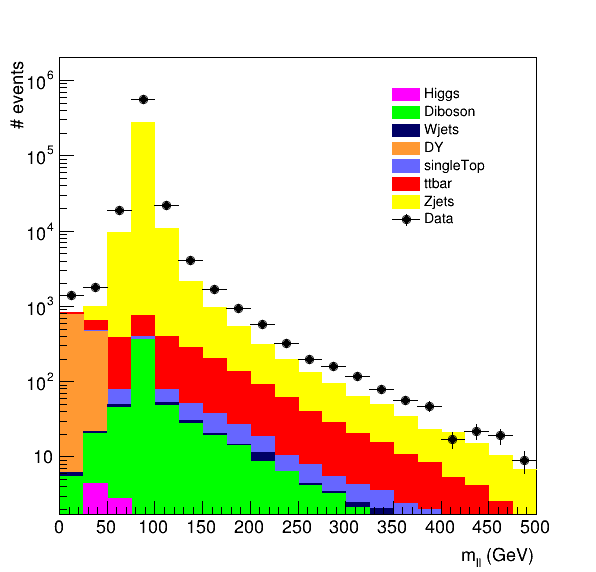

In [37]:
stack_mll->Draw("hist"); 
stack_mll->SetMaximum(1E6); 
stack_mll->GetYaxis()->SetTitle("# events");
stack_mll->GetYaxis()->SetTitleOffset(1.3); 
stack_mll->GetXaxis()->SetTitle("m_{ll} (GeV)");
stack_mll->GetXaxis()->SetTitleOffset(1.3);
hist_mll_d->Draw("same E"); 
leg->Draw();
C->Draw();